## Analysis of MovieLens Data - Part 3

In this part we will continue working with the movielens data collected by the GroupLens Research Project at the University of Minnesota. The columns in the dataset are a little bit different from the ones provided in the previous parts, where the 'rating' column is replaced by the 'feedback' column. There are two values regarding the 'feedback' with 1 indicating the user likes the corresponding movie; otherwise 0. 

The header of the csv file is shown below. 

| userId | age | gender | occupation| movieId | feedback | genre | timestamp |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __age__ - the user's age
* __gender__ - the user's gender
* __occupation__ - the user's occupation
* __movieId__ - the movie's id
* __feedback__ - the user's feedback towards the movie (1 means 'like'; 0 means 'dislike')
* __genre__ - the genre of the movie
* __timestamp__ - the timestamp indicating when the user rated the movie

Note that, a same user (i.e., a same userId) corresponds to a same age/gender/occupation; a same movie (i.e., a same movieId) corresponds to a same genre; a same user (i.e., a same userId) may like multiple movies and a same movie (i.e., a same movieId) may be preferred by multiple users.


Our high level goal in this part, is to try to build and evaluate predictive models for feedback from available features - predict the value of the __feedback__ field in the data from some of the other fields. Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.

### Importing the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('files/movielens_data_feedback.csv')
df.head(10)

,userId,age,gender,occupation,movieId,feedback,genre,timestamp
0,196,49,M,writer,242,0,Comedy,881250949
1,186,39,F,executive,302,0,Crime,891717742
2,22,25,M,writer,377,0,Children,878887116
3,244,28,M,technician,51,0,Romance,880606923
4,166,47,M,educator,346,0,Drama,886397596
5,298,44,M,executive,474,1,War,884182806
6,115,31,M,engineer,265,0,Action,881171488
7,253,26,F,librarian,465,1,Adventure,891628467
8,305,23,M,programmer,451,0,Romance,886324817
9,6,42,M,executive,86,0,Drama,883603013


In [3]:
df.shape

(100000, 8)

In [4]:
df.describe()

,userId,age,movieId,feedback,timestamp
count,100000.00000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,32.969850,425.530130,0.553750,8.835289e+08
std,266.61442,11.562623,330.798356,0.497105,5.343856e+06
min,1.00000,7.000000,1.000000,0.000000,8.747247e+08
25%,254.00000,24.000000,175.000000,0.000000,8.794487e+08
50%,447.00000,30.000000,322.000000,1.000000,8.828269e+08
75%,682.00000,40.000000,631.000000,1.000000,8.882600e+08
max,943.00000,73.000000,1682.000000,1.000000,8.932866e+08


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   userId      100000 non-null  int64 
 1   age         100000 non-null  int64 
 2   gender      100000 non-null  object
 3   occupation  100000 non-null  object
 4   movieId     100000 non-null  int64 
 5   feedback    100000 non-null  int64 
 6   genre       100000 non-null  object
 7   timestamp   100000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


### Checking the distribution of the feedback column, our new feature


In [6]:
df.groupby('feedback').size()

feedback
0    44625
1    55375
dtype: int64

<AxesSubplot:xlabel='feedback', ylabel='count'>

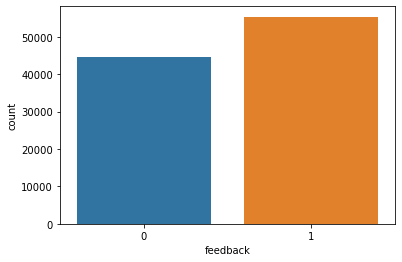

In [7]:
# Visualising countplot

sns.countplot(df['feedback'], label="Count")

### Observations:
* Number of likes = 55,375
* Number of dislikes = 44,625
* There is an imbalance in the feedback column i.e. the number of samples of each category(here, likes and dislikes) are different.

---

### Generating new suitable dataframe.

In [8]:
# making a new dataframe 'data' from 'df' to exclude unique Id's and timpstamp

data = pd.DataFrame(df[['age', 'gender', 'occupation', 'feedback', 'genre']])


# transforming the categorical features to numerical features

ord_enc = OrdinalEncoder(dtype=int)
data[["genre_code", "gender_code", "occupation_code"]] = ord_enc.fit_transform(data[["genre", "gender", "occupation"]])

dataset = data.drop(['genre','gender', 'occupation'], axis=1)
dataset.head(10)

,age,feedback,genre_code,gender_code,occupation_code
0,49,0,4,1,20
1,39,0,5,0,6
2,25,0,3,1,20
3,28,0,13,1,19
4,47,0,7,1,3
5,44,1,16,1,6
6,31,0,0,1,4
7,26,1,1,0,10
8,23,0,13,1,14
9,42,0,7,1,6


### Checking the relationship of 'feedback' with other features

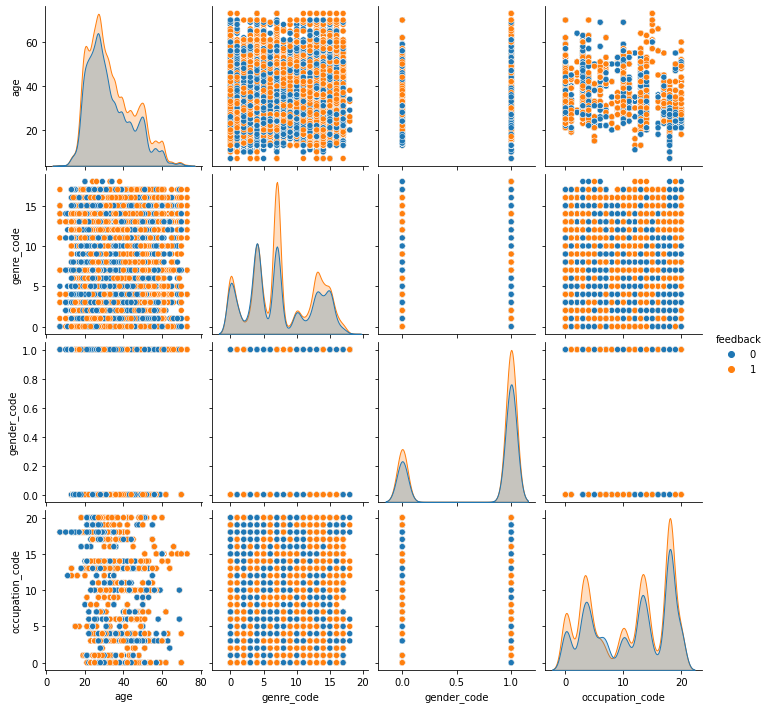

In [9]:
sns.pairplot(dataset, hue="feedback")

In [10]:
dataset.corr()

,age,feedback,genre_code,gender_code,occupation_code
age,1.000000,0.039317,0.027601,0.033358,-0.369476
feedback,0.039317,1.000000,0.041401,-0.001126,-0.022800
genre_code,0.027601,0.041401,1.000000,-0.001079,-0.011759
gender_code,0.033358,-0.001126,-0.001079,1.000000,0.017354
occupation_code,-0.369476,-0.022800,-0.011759,0.017354,1.000000


#### 'feedback' seems to have weak correlations with other features, amongst all 'genre_code' has the highest correlation with 'feedback'.
___

### Building the predictive models:
* A) Simple Method - Logistic Regression Model
* B) Advanced Method - KNN Classifier Model

## a) Simple Method: Logistic Regression Model

### 1. Dividing the dataset into training and testing for predictive model

In [11]:
# considering all the features including unique ids and timestamps, default distribution of training and testing
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['feedback'], axis=1), dataset['feedback'], stratify=dataset['feedback'], random_state=17)

# checking shapes of each
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train shape:  (75000, 4)
y_train shape:  (75000,)
X_test shape:  (25000, 4)
y_test.shape:  (25000,)


### 2. Applying Logistic Regression Model

In [12]:
lr = LogisticRegression().fit(X_train, y_train)

In [13]:
# making predictions on training and test set
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# calculating accuracy score on training set
print("Accuracy on training set: ", accuracy_score(y_train, y_pred_train))

# calculating accuracy score on test set
print("Accuracy on test set: ", accuracy_score(y_test, y_pred_test))

Accuracy on training set:  0.5529866666666666
Accuracy on test set:  0.55292


### 3. Finding important features for the predictive model

In [14]:
rfe = RFE(lr, 3)
rfe_model = rfe.fit(X_train, y_train)
print("No. of features: ", rfe_model.n_features_)
print("Selected features: ", rfe_model.support_)
print("Features ranking: ", rfe_model.ranking_)

No. of features:  3
Selected features:  [ True  True False  True]
Features ranking:  [1 1 2 1]


#### 'age', 'genre_code' and 'occupation_code' have been given ranking as 1 by the RFE so we'll re-fit the logistic regression with any one of these features.

### 4. Estimating accuracy score on test set using RFE by using different number of features.

In [15]:
acc_scores = []
for i in range(1,5):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Accuracy on test set using", i, "feature/s: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)


Accuracy on test set using 1 feature/s:  0.55376
Accuracy on test set using 2 feature/s:  0.55332
Accuracy on test set using 3 feature/s:  0.55276
Accuracy on test set using 4 feature/s:  0.55292


### -> We'll re-fit the logistic regression with one of the features that have been ranked 1 above.

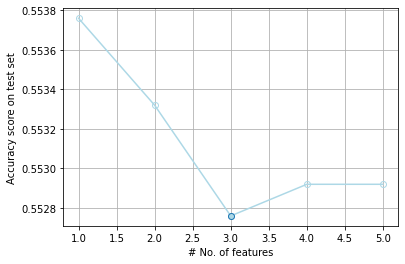

In [16]:

estimator = LogisticRegression()
acc_scores = []
for i in range(1, 6):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 6), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')


#### The graph depicts that the highest accuracy score is achievable while using a single feature column except the "feedback" feature from the dataframe "dataset". 

### 5. Re-fitting the logistic regression model with the most important feature 'age' along with 'feedback' feature. 


In [17]:
# considering all the features including unique ids and timestamps, default distribution of training and testing
x_train, x_test, Y_train, Y_test = train_test_split(dataset.drop(['genre_code', 'gender_code', 'occupation_code','feedback'], axis=1), dataset['feedback'], stratify=dataset['feedback'], random_state=17)

# checking shapes of each
print("x_train shape: ", x_train.shape)
print("Y_train shape: ", Y_train.shape)
print("x_test shape: ", x_test.shape)
print("Y_test.shape: ", Y_test.shape)

x_train shape:  (75000, 1)
Y_train shape:  (75000,)
x_test shape:  (25000, 1)
Y_test.shape:  (25000,)


In [18]:
lr = LogisticRegression().fit(x_train, Y_train)

In [19]:
# making predictions on training and test set
Y_pred_train = lr.predict(x_train)
Y_pred_test = lr.predict(x_test)

# calculating accuracy score on training set
print("Accuracy on training set: ", accuracy_score(Y_train, Y_pred_train))

# calculating accuracy score on test set
print("Accuracy on test set: ", accuracy_score(Y_test, Y_pred_test))

Accuracy on training set:  0.5537466666666667
Accuracy on test set:  0.55376


### *After selecting the top feature through RFE, the accuracy of the model is now higher than the model that was used before.* 
___________________

## b) Advanced Method: KNN Classifier Model

### 1. Creating and training a KNN classifier model

In [20]:
neigh = KNeighborsClassifier(n_neighbors = 20)
neigh.fit(x_train, Y_train)

KNeighborsClassifier(n_neighbors=20)

### 2. Using the model to predict the testing data

In [21]:
Y_pred = neigh.predict(x_test)

print("Testing accuracy is: ", accuracy_score(Y_pred, Y_test))

Testing accuracy is:  0.54376


### 3. Plotting the accurcy trend w.r.t. K

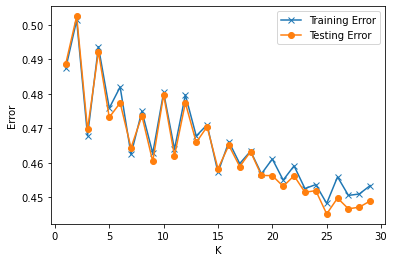

In [22]:
training_error=list()
testing_error=list()

for i in range(1, 30):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(x_train, Y_train)
    training_error.append(1.0-accuracy_score(clf.predict(x_train), Y_train))
    testing_error.append(1.0-accuracy_score(clf.predict(x_test), Y_test))

# Plot the relationship
plt.plot(range(1, 30), training_error, marker='x', label='Training Error')
plt.plot(range(1, 30), testing_error, marker='o', label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

### 4. K-Fold Cross Validation

In [23]:
# Creating a KNN classifier model and using k-fold cross validation for testing accuracy estimation

clf = KNeighborsClassifier(n_neighbors = 30)
scores = cross_val_score(clf, x_train, Y_train, cv=20)
print('Accuracy for each round: \n', scores)
print('Average accuracy: %.4f +- %.4f' % (scores.mean(), scores.std()))

Accuracy for each round: 
 [0.50933333 0.52613333 0.51653333 0.536      0.51626667 0.54106667
 0.53013333 0.544      0.5344     0.52453333 0.5344     0.53813333
 0.52933333 0.5272     0.54373333 0.54026667 0.53413333 0.5336
 0.53333333 0.53706667]
Average accuracy: 0.5315 +- 0.0091


### 5. Automatic model hyperparameter tuning

In [24]:
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 30)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(x_train, Y_train)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  27
The accuracy:  0.5365733333333333


### In the advanced method: KNN classifier model, we have found the best K value(within range(1-30) of neighbors) and it's accuracy score through automatic model hyperparameter tuning. 
---


## *SUMMARY*

### The misclassification rates of Logistic regression is less than the misclassification of KNN. In other words, the accuracy score of logistic regression is more than the KNN. However, both are very close to 0.5. Neither is good enough in practice.
____